In [1]:
%matplotlib inline
import pylab
import numpy as np
import functools
import adapt_float
import adapt_spike
import adapt_fixed_small

import ctn_benchmark.control as ctrl

In [19]:
def objective(args, adapt_type):
    D = 1
    dt=0.001
    T = 20.0
    seed=2
    noise=0.1
    Kp=args['Kp']
    Kd=args['Kd']
    Ki=args['Ki']
    print 'trying', Kp, Kd, Ki
    tau_d=0.001
    period=4
    amplitude=1
    n_neurons=500
    learning_rate=1
    max_freq=1.0
    synapse=0.01
    scale_add=2
    delay=0.01
    filter=0.01

    n_neurons=256

    signal = ctrl.Signal(D, period, dt=dt, max_freq=max_freq, seed=seed)

    system = ctrl.System(D, D, dt=dt, seed=seed,
            motor_noise=noise, sense_noise=noise,
            scale_add=scale_add,
            motor_scale=10,
            motor_delay=delay, sensor_delay=delay,
            motor_filter=filter, sensor_filter=filter)

    pid = ctrl.PID(Kp, Kd, Ki, tau_d=tau_d)
    
    if adapt_type == 'float':
        adapt = adapt_float.AdaptiveFloat(n_inputs=D, n_outputs=D, n_neurons=n_neurons, seed=seed,
                                     learning_rate=1e-4)
        scale = 1.0
    elif adapt_type == 'fixed':
        adapt = adapt_fixed_small.AdaptiveFixed(n_inputs=D, n_outputs=D, n_neurons=n_neurons, seed=seed,
                                                input_bits=8,
                                                state_bits=8,
                                                extra_bits=4,
                                                decoder_offset=4,
                                                decoder_bits=8,
                                                smoothing=10,
                                                learning_rate=1e-4)
        scale = adapt.input_max
    else:
        adapt = None

    steps = int(T / dt)
    time = np.arange(steps)*dt
    data_desired = np.zeros((steps, D))
    data_actual = np.zeros((steps, D))
    data_pid = np.zeros((steps, D))
    data_error = np.zeros((steps, D))

    for i in range(steps):
        desired = signal.value(i*dt)*amplitude
        data_desired[i,:] = desired

        actual = system.state
        data_actual[i,:] = actual

        raw_pid = pid.step(actual, desired)
        data_pid[i,:] = raw_pid

        if adapt is not None:
            adjust = adapt.step(actual*scale, -raw_pid*scale)/scale
        else:
            adjust = 0
            
        system.step(raw_pid + adjust)
        
    #pylab.plot(data_desired)
    #pylab.plot(data_actual)
        
    rmse = np.sqrt(np.mean((data_desired - data_actual)**2))
        
    return dict(
        status='ok',
        loss=rmse
        )


In [20]:
objective(dict(Kp=10, Kd=2, Ki=0), adapt_type='none')

trying 10 2 0


{'loss': 0.072578950102291276, 'status': 'ok'}

In [21]:
objective(dict(Kp=10, Kd=2, Ki=0), adapt_type='fixed')

trying 10 2 0


{'loss': 0.072970952117567919, 'status': 'ok'}

In [22]:
objective(dict(Kp=10, Kd=2, Ki=0), adapt_type='float')

trying 10 2 0


{'loss': 0.059855123871354471, 'status': 'ok'}

In [23]:
import hyperopt as hp

space = dict(
    Kp=hp.hp.lognormal('Kp', np.log(50), 1),
    Kd=hp.hp.lognormal('Kd', np.log(20), 1),
    Ki=hp.hp.lognormal('Ki', np.log(10), 1)
)

trials = hp.Trials()



In [24]:
import functools
best = hp.fmin(functools.partial(objective, adapt_type='fixed'), space=space, algo=hp.tpe.suggest, max_evals=100, trials=trials)

trying 48.0636816073 16.2987669305 2.46178366298
trying 92.5729886695 65.0721638221 4.91166141722
trying 48.0398255288 3.17482782935 3.19844471815
trying 17.9539178295 88.7210425554 15.6807818443
trying 74.8258451113 6.99973237925 20.2892323172
trying 8.43359536229 9.99713979308 13.8032569622
trying 897.076064842 28.6485988342 5.7337186985
trying 7.5009130424 14.4902233997 3.07147213852
trying 35.8666531335 16.6624350367 28.0480475585
trying 110.163033325 11.3324356337 18.6203292967
trying 54.3198948901 18.9432649878 21.4039280332
trying 128.07416403 12.3182046412 4.56613353946
trying 26.6975591582 3.63792779669 6.10351552529
trying 17.3133828666 15.4765039702 6.57461542176
trying 154.735393575 11.0165492512 20.556972767
trying 20.4648568995 20.6184201207 5.4720307666
trying 44.4673737099 18.3526371101 17.6197533515
trying 21.2545245067 17.6608414429 4.5114527937
trying 15.5493181917 11.2995708554 19.8429364432
trying 39.3132823447 20.6080107599 8.35235393022
trying 11.9957169664 299.9

In [25]:
best

{'Kd': 29.854784017116174, 'Ki': 6.0614564913019953, 'Kp': 14.741786642982683}

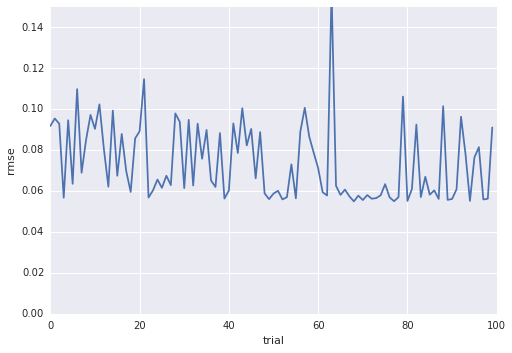

best rmse 0.0549544908238


In [26]:
loss = [t['result']['loss'] for t in trials.trials]
pylab.plot(loss)
pylab.xlabel('trial')
pylab.ylabel('rmse')
pylab.ylim(0, 0.15)
pylab.show()
print 'best rmse', np.min(loss)

In [27]:
limits = [1.0, 1.05, 1.1, np.inf]
limit_labels = ['<5%', '5-10%', '10%+']
best_rmse = np.min(loss)
data = []
for t in trials.trials:
    d = {}
    d['Kp'] = t['misc']['vals']['Kp'][0]
    d['Kd'] = t['misc']['vals']['Kd'][0]
    d['Ki'] = t['misc']['vals']['Ki'][0]
    rate = t['result']['loss'] / best_rmse
    index = 0
    while limits[index+1] < rate:
        index += 1
    d['category'] = limit_labels[index]
    
    data.append(d)


In [28]:
import pandas
import seaborn as sns

In [29]:
df = pandas.DataFrame(data)

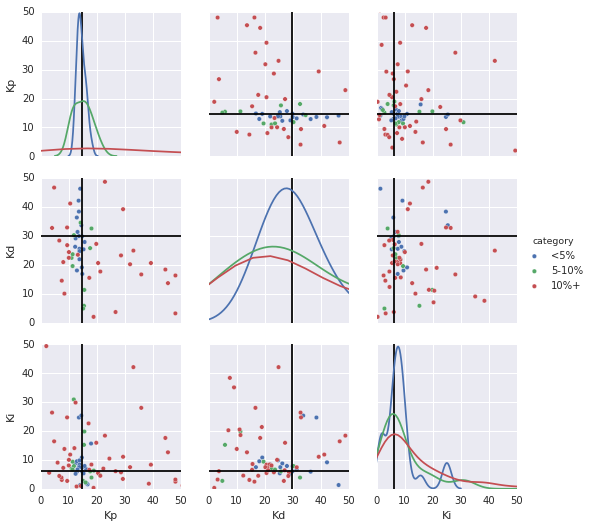

In [30]:
grid = sns.pairplot(data=df, x_vars=['Kp', 'Kd', 'Ki'], y_vars=['Kp', 'Kd', 'Ki'], diag_kind='kde', hue='category', hue_order=limit_labels)
ax_lim=50
for i, row in enumerate(grid.axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.set_xlim(0, ax_lim)
        else:
            ax.set_xlim(0, ax_lim)
            ax.set_ylim(0, ax_lim)
        
best_vals = best['Kp'], best['Kd'], best['Ki']
for i, row in enumerate(grid.axes):
        for j, ax in enumerate(row):
            if i==j:
                ax.axvline(best_vals[i], c='k')
            else:
                ax.axvline(best_vals[j], c='k')
                ax.axhline(best_vals[i], c='k')            